In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics.pairwise import euclidean_distances


x,y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant= 0, n_clusters_per_class=1, random_state=60)
X_train, X_test, y_train, y_test = train_test_split(x,y,stratify=y,random_state=42)

# del X_train,X_test

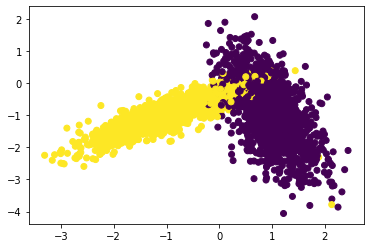

In [2]:
%matplotlib inline
colors = {0:'red', 1:'blue'}
plt.scatter(X_test[:,0], X_test[:,1],c=y_test)
plt.show()

# Implementing Custom RandomSearchCV

<pre>
def RandomSearchCV(x_train,y_train,classifier, param_range, folds):
    # x_train: its numpy array of shape, (n,d)
    # y_train: its numpy array of shape, (n,) or (n,1)
    # classifier: its typically KNeighborsClassifier()
    # param_range: its a tuple like (a,b) a < b
    # folds: an integer, represents number of folds we need to devide the data and test our model
    
    
    #1.generate 10 unique values(uniform random distribution) in the given range "param_range" and store them as "params" 
    # ex: if param_range = (1, 50), we need to generate 10 random numbers in range 1 to 50
    #2.devide numbers ranging from  0 to len(X_train) into groups= folds
    # ex: folds=3, and len(x_train)=100, we can devide numbers from 0 to 100 into 3 groups 
      group 1: 0-33, group 2:34-66, group 3: 67-100
    #3.for each hyperparameter that we generated in step 1:
        # and using the above groups we have created in step 2 you will do cross-validation as follows
        
        # first we will keep group 1+group 2 i.e. 0-66 as train data and group 3: 67-100 as test data, and find train and
          test accuracies
          
        # second we will keep group 1+group 3 i.e. 0-33, 67-100 as train data and group 2: 34-66 as test data, and find
          train and test accuracies
          
        # third we will keep group 2+group 3 i.e. 34-100 as train data and group 1: 0-33 as test data, and find train and
          test accuracies
        # based on the 'folds' value we will do the same procedure
        
        # find the mean of train accuracies of above 3 steps and store in a list "train_scores"
        # find the mean of test accuracies of above 3 steps and store in a list "test_scores"
    #4. return both "train_scores" and "test_scores"

#5. call function RandomSearchCV(x_train,y_train,classifier, param_range, folds) and store the returned values into "train_score", and "cv_scores"
#6. plot hyper-parameter vs accuracy plot as shown in reference notebook and choose the best hyperparameter
#7. plot the decision boundaries for the model initialized with the best hyperparameter, as shown in the last cell of reference notebook

</pre>

In [6]:
def pick_unique_random_numbers(lo,hi,n):
    rl=[]
    rl.append(int(np.random.uniform(lo,hi)))
    while(True):
        n1=int(np.random.uniform(lo,hi))
        if(n1 in rl):
            continue
        else:
            rl.append(n1)
        if(len(rl)==n):
            break
    rl.sort()
    return rl

In [7]:
def grouping_elements(n,ng):
    d_gi={}
    s=0
    e=n//ng
    c=n//ng
    for i in range(0,ng):
        if(i==ng-1):
            e=n
            d_gi[i]=[s,e]
        else:
            d_gi[i]=[s,e]
        s=e
        e=e+c    
    return d_gi

In [8]:
def RandomSearchCV(x_train,y_train,classifier,params,folds):
    trainscores = []
    testscores  = []   
    list_k=pick_unique_random_numbers(params[0],params[1],10)
    d_gi=grouping_elements(len(x_train),folds)
    for k in tqdm(list_k):
        trainscores_folds = []
        testscores_folds  = []
        for f in range(0,folds):
            tl=[]
            c=0
            x_te=x_train[d_gi[f][0]:d_gi[f][1]]
            y_te=y_train[d_gi[f][0]:d_gi[f][1]]
            for i in range(0,folds):
                if(i==f):
                    continue
                else:
                    tl.append(i)
            for i in tl:
                c=c+1
                if(c==1):
                    x_tr=x_train[d_gi[i][0]:d_gi[i][1]]
                    y_tr=y_train[d_gi[i][0]:d_gi[i][1]]
                else:
                    x_tr=np.concatenate((x_tr,x_train[d_gi[i][0]:d_gi[i][1]]))
                    y_tr=np.concatenate((y_tr,y_train[d_gi[i][0]:d_gi[i][1]]))
            
            classifier.n_neighbors=k
            classifier.fit(x_tr,y_tr)
            
            y_pred=classifier.predict(x_te)
            testscores_folds.append(accuracy_score(y_te,y_pred))
            
            y_pred=classifier.predict(x_tr)
            trainscores_folds.append(accuracy_score(y_tr,y_pred))
            
        trainscores.append(np.mean(np.array(trainscores_folds)))
        testscores.append(np.mean(np.array(testscores_folds)))
    
    return trainscores,testscores,list_k

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.29s/it]


--------------------------------------------------------------------------------
k-values : [11, 15, 16, 26, 33, 36, 38, 39, 41, 45]
--------------------------------------------------------------------------------


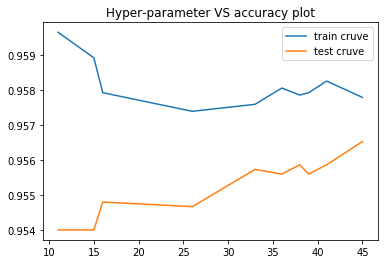

In [10]:
import warnings
warnings.filterwarnings("ignore")


neigh = KNeighborsClassifier()

params = (1,50)
folds = 3

trs,tes,lk = RandomSearchCV(X_train,y_train,neigh,params,folds)
print('-'*80)
print('k-values : {}'.format(lk))
print('-'*80)
 

plt.plot(lk[:],trs, label='train cruve')
plt.plot(lk[:],tes, label='test cruve')
plt.title('Hyper-parameter VS accuracy plot')
plt.legend()
plt.show()

In [11]:
# understanding this code line by line is not that importent 
def plot_decision_boundary(X1, X2, y, clf):
        # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    x_min, x_max = X1.min() - 1, X1.max() + 1
    y_min, y_max = X2.min() - 1, X2.max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    # Plot also the training points
    plt.scatter(X1, X2, c=y, cmap=cmap_bold)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("2-Class classification (k = %i)" % (clf.n_neighbors))
    plt.show()

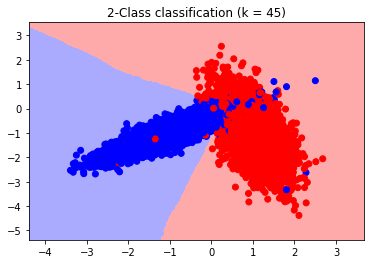

In [13]:
neigh = KNeighborsClassifier(n_neighbors = 45)
neigh.fit(X_train, y_train)
plot_decision_boundary(X_train[:, 0], X_train[:, 1], y_train, neigh)

# sklearn implementation of RandomSearchCV

In [2]:
neigh = KNeighborsClassifier()
folds = 3

In [3]:
from sklearn.model_selection import RandomizedSearchCV

In [4]:
d={'n_neighbors': range(1,50)}

In [32]:
rs=RandomizedSearchCV(estimator=neigh,param_distributions=d,cv=3,scoring='roc_auc',n_iter=5)

In [33]:
rs.fit(X_train,y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=KNeighborsClassifier(algorithm='auto',
                                                  leaf_size=30,
                                                  metric='minkowski',
                                                  metric_params=None,
                                                  n_jobs=None, n_neighbors=5,
                                                  p=2, weights='uniform'),
                   iid='warn', n_iter=5, n_jobs=None,
                   param_distributions={'n_neighbors': range(1, 50)},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='roc_auc', verbose=0)

In [34]:
rs.best_params_

{'n_neighbors': 25}

In [26]:
import pandas as pd

In [35]:
sdf=pd.DataFrame.from_dict(rs.cv_results_)
sdf.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006693,0.005892,0.048628,0.013102,35,{'n_neighbors': 35},0.985903,0.987673,0.990280,0.987951,0.001798,4
1,0.004555,0.000419,0.049194,0.010576,42,{'n_neighbors': 42},0.985700,0.987976,0.990155,0.987943,0.001819,5


In [36]:
sdf.sort_values(['param_n_neighbors'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
3,0.003292,0.000423,0.029305,0.007559,25,{'n_neighbors': 25},0.985540,0.988089,0.990531,0.988053,0.002038,1
4,0.002683,0.000485,0.029507,0.001071,30,{'n_neighbors': 30},0.985468,0.987896,0.990502,0.987955,0.002056,3
0,0.006693,0.005892,0.048628,0.013102,35,{'n_neighbors': 35},0.985903,0.987673,0.990280,0.987951,0.001798,4
2,0.004025,0.000849,0.048727,0.005013,39,{'n_neighbors': 39},0.985668,0.988016,0.990217,0.987966,0.001857,2
1,0.004555,0.000419,0.049194,0.010576,42,{'n_neighbors': 42},0.985700,0.987976,0.990155,0.987943,0.001819,5


In [37]:
sdf

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006693,0.005892,0.048628,0.013102,35,{'n_neighbors': 35},0.985903,0.987673,0.990280,0.987951,0.001798,4
1,0.004555,0.000419,0.049194,0.010576,42,{'n_neighbors': 42},0.985700,0.987976,0.990155,0.987943,0.001819,5
2,0.004025,0.000849,0.048727,0.005013,39,{'n_neighbors': 39},0.985668,0.988016,0.990217,0.987966,0.001857,2
3,0.003292,0.000423,0.029305,0.007559,25,{'n_neighbors': 25},0.985540,0.988089,0.990531,0.988053,0.002038,1
4,0.002683,0.000485,0.029507,0.001071,30,{'n_neighbors': 30},0.985468,0.987896,0.990502,0.987955,0.002056,3


In [39]:
sdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 12 columns):
mean_fit_time        5 non-null float64
std_fit_time         5 non-null float64
mean_score_time      5 non-null float64
std_score_time       5 non-null float64
param_n_neighbors    5 non-null object
params               5 non-null object
split0_test_score    5 non-null float64
split1_test_score    5 non-null float64
split2_test_score    5 non-null float64
mean_test_score      5 non-null float64
std_test_score       5 non-null float64
rank_test_score      5 non-null int32
dtypes: float64(9), int32(1), object(2)
memory usage: 588.0+ bytes
